In [11]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Getting data

In [2]:
scale = 28
distortion_scale = 0.3
# TODO
transform = transforms.Compose([
    transforms.Resize((scale, scale)),
    transforms.ToTensor(),
    transforms.RandomRotation((-45, 45)),
    transforms.RandomPerspective(distortion_scale=distortion_scale, p=0.5),
    transforms.Normalize(mean=(0.1307,), std=(0.3081,))
])

In [3]:
train_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 9912422/9912422 [00:00<00:00, 206618185.29it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 100946411.52it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 75625664.54it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 19782480.55it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



# Train/Test split

In [4]:
batch = 64

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch, shuffle=True, num_workers=0)

# Visualization

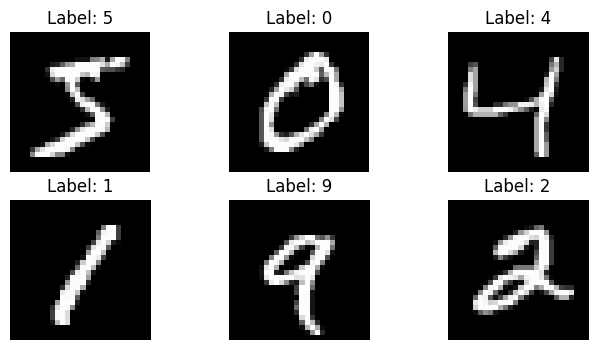

In [69]:
fig, axes = plt.subplots(2, 3, figsize=(8, 4))

for i in range(6):
  img, label = train_data[i]
  row, col = i // 3, i % 3
  axes[row, col].imshow(img.permute(1, 2, 0), cmap='gray')
  axes[row, col].set_title(f"Label: {label}")
  axes[row, col].axis('off')

# Models

In [5]:
def training(model, opt, criterion, train_loader, val_loader, epochs=10):
  train_acc, train_loss, val_acc, val_loss, = [], [], [], []

  for epoch in range(epochs):
    running_loss = running_loss_val = 0.0
    total = total_val = correct = correct_val = 0

    # Training
    for inputs, labels in train_loader: # Loop through every batch
        labels = labels.type(torch.LongTensor) 
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Reset gradient
        optimizer.zero_grad()

        # Feedforward
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backprop
        loss.backward()
        optimizer.step()

        # Get prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Accumulate loss
        running_loss += loss.item()

    accuracy = 100 * correct / total
    train_acc.append(accuracy)

    avg_loss = running_loss / len(train_loader)
    train_loss.append(avg_loss)

    # Validation
    with torch.no_grad():
      for inputs_val, labels_val in val_loader:
        labels_val = labels_val.type(torch.LongTensor) 
        inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)

        outputs_val = model(inputs_val)
        loss_val = criterion(outputs_val, labels_val)

        _, predicted_val = torch.max(outputs_val.data, 1)
        total_val += labels_val.size(0)
        correct_val += (predicted_val == labels_val).sum().item()

        running_loss_val += loss_val.item()

      accuracy_val = 100 * correct_val / total_val
      avg_loss_val = running_loss_val / len(val_loader)
      val_acc.append(accuracy_val)
      val_loss.append(avg_loss_val)

    print("The loss for Epoch {} is: {}, Accuracy = {}".format(epoch, running_loss/len(train_loader), accuracy))
  return train_acc, train_loss, val_acc, val_loss

## Logistic Regression

In [15]:
class LogReg(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()
    self.linear = nn.Linear(in_features=28*28, out_features=10, bias=True)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    return self.sigmoid(self.linear(self.flatten(x)))


In [16]:
log_model = LogReg()
optimizer = optim.Adam(log_model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()
epochs = 10

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
log_model.to(device)

LogReg(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=784, out_features=10, bias=True)
  (sigmoid): Sigmoid()
)

In [74]:
train_acc_log, train_loss_log, val_acc_log, val_loss_log = training(log_model, optimizer, criterion, train_loader, test_loader, epochs=epochs)

The loss for Epoch 0 is: 2.2461621578314155, Accuracy = 32.85
The loss for Epoch 1 is: 2.172289068256614, Accuracy = 58.695
The loss for Epoch 2 is: 2.109081223066936, Accuracy = 69.84666666666666
The loss for Epoch 3 is: 2.0548878258733607, Accuracy = 74.63833333333334
The loss for Epoch 4 is: 2.0085826104383733, Accuracy = 77.095
The loss for Epoch 5 is: 1.9690120290083164, Accuracy = 78.49666666666667
The loss for Epoch 6 is: 1.9350874261307056, Accuracy = 79.375
The loss for Epoch 7 is: 1.9058802586628685, Accuracy = 80.22333333333333
The loss for Epoch 8 is: 1.8805594716244922, Accuracy = 80.71166666666667
The loss for Epoch 9 is: 1.8585546737286582, Accuracy = 81.26333333333334


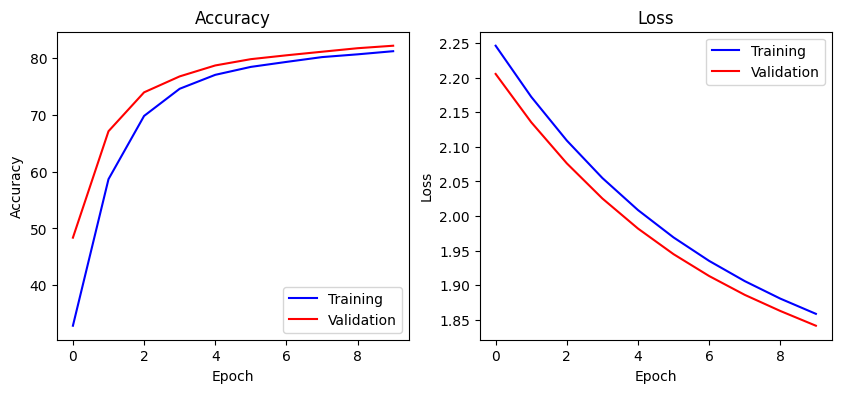

In [75]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].set_title("Accuracy")
axes[0].plot(range(epochs), train_acc_log, 'b', label='Training')
axes[0].plot(range(epochs), val_acc_log, 'r', label='Validation')
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].legend()

axes[1].set_title("Loss")
axes[1].plot(range(epochs), train_loss_log, 'b', label='Training')
axes[1].plot(range(epochs), val_loss_log, 'r', label='Validation')
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].legend()

## Neural Network

In [76]:
class NeuralNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten(start_dim=1)
    self.hidden = nn.Linear(in_features=28*28, out_features=256, bias=True)
    self.linear = nn.Linear(in_features=256, out_features=10, bias=True)
    self.softmax = nn.Softmax(dim=1)

  def forward(self, x):
    return self.softmax(self.linear(self.hidden(self.flatten(x))))

In [80]:
neural_model = NeuralNet()
optimizer = optim.Adam(neural_model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()
neural_model.to(device)

NeuralNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (hidden): Linear(in_features=784, out_features=256, bias=True)
  (linear): Linear(in_features=256, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)

In [81]:
train_acc_nn, train_loss_nn, val_acc_nn, val_loss_nn = training(neural_model, optimizer, criterion, train_loader, test_loader, epochs=epochs)

The loss for Epoch 0 is: 2.208273174666138, Accuracy = 51.35666666666667
The loss for Epoch 1 is: 1.976762527214693, Accuracy = 64.20333333333333
The loss for Epoch 2 is: 1.8393250719062302, Accuracy = 74.73
The loss for Epoch 3 is: 1.7654117755035856, Accuracy = 79.025
The loss for Epoch 4 is: 1.7148227184566098, Accuracy = 82.885
The loss for Epoch 5 is: 1.674726676839247, Accuracy = 86.20833333333333
The loss for Epoch 6 is: 1.6491908828841089, Accuracy = 87.67666666666666
The loss for Epoch 7 is: 1.6318224452451857, Accuracy = 88.505
The loss for Epoch 8 is: 1.6193438282907644, Accuracy = 89.02
The loss for Epoch 9 is: 1.6098142289149482, Accuracy = 89.365


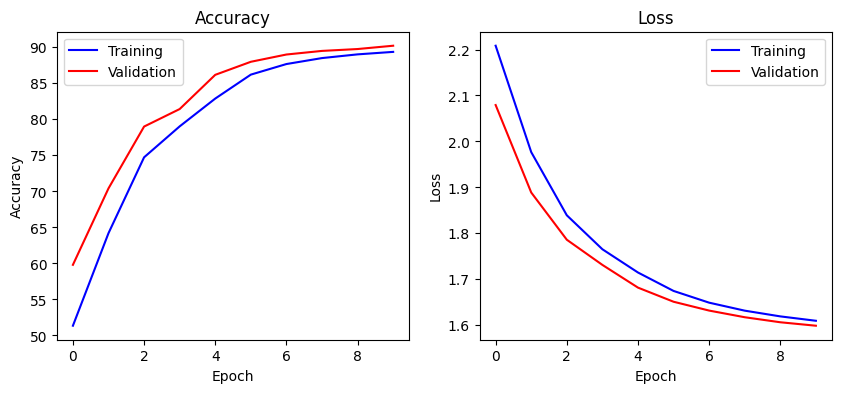

In [82]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].set_title("Accuracy")
axes[0].plot(range(epochs), train_acc_nn, 'b', label='Training')
axes[0].plot(range(epochs), val_acc_nn, 'r', label='Validation')
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].legend()

axes[1].set_title("Loss")
axes[1].plot(range(epochs), train_loss_nn, 'b', label='Training')
axes[1].plot(range(epochs), val_loss_nn, 'r', label='Validation')
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].legend()

## CNN

In [30]:
import math

def feature_map_dim(input_dim, padding, kernel_size, stride):
  return math.floor(((input_dim - kernel_size + 2 * padding) / stride) + 1)

In [29]:
c1_conv_out = feature_map_dim(28, 0, 5, 1)
c1_out = feature_map_dim(c1_conv_out, 0, 2, 2)
conv_out = feature_map_dim(c1_out, 0, 5, 1)
c2_out = feature_map_dim(conv_out, 0, 2, 2)
c2_out

4

In [38]:
class CNN(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=32, padding=0, kernel_size=5, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout(p=0.2)
    )

    self.conv2 = nn.Sequential(
        nn.Conv2d(in_channels=32, out_channels=64, padding=0, kernel_size=5, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout(p=0.2)
    )

    c1_conv_out = feature_map_dim(28, 0, 5, 1)
    c1_out = feature_map_dim(c1_conv_out, 0, 2, 2)
    conv_out = feature_map_dim(c1_out, 0, 5, 1)
    c2_out = feature_map_dim(conv_out, 0, 2, 2)

    self.flatten = nn.Flatten(start_dim=1)
    self.fc1 = nn.Linear(64 * c2_out * c2_out, 64 * c2_out)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(64 * c2_out, 64)
    self.fc3 = nn.Linear(64, 10)
    self.softmax = nn.Softmax(dim=1)

  def forward(self, x):
    outputs = self.conv2(self.conv1(x))
    outputs = self.flatten(outputs)
    outputs = self.relu(self.fc1(outputs))
    outputs = self.relu(self.fc2(outputs))
    return self.softmax(self.fc3(outputs))

In [39]:
cnn_model = CNN()
optimizer = optim.Adam(cnn_model.parameters(), lr=1e-5, weight_decay=0.001) # L2 regularization 
criterion = nn.CrossEntropyLoss()
cnn_model.to(device)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)

In [40]:
train_acc_cnn, train_loss_cnn, val_acc_cnn, val_loss_cnn = training(cnn_model, optimizer, criterion, train_loader, test_loader, epochs=epochs)

The loss for Epoch 0 is: 2.2119925506333553, Accuracy = 35.86833333333333
The loss for Epoch 1 is: 1.804975165614187, Accuracy = 74.015
The loss for Epoch 2 is: 1.675409920052933, Accuracy = 83.75833333333334
The loss for Epoch 3 is: 1.632647626816845, Accuracy = 86.09
The loss for Epoch 4 is: 1.612783174397849, Accuracy = 87.195
The loss for Epoch 5 is: 1.5976261760888577, Accuracy = 88.23166666666667
The loss for Epoch 6 is: 1.5879335576283145, Accuracy = 88.90333333333334
The loss for Epoch 7 is: 1.5795116195800716, Accuracy = 89.62166666666667
The loss for Epoch 8 is: 1.5711270021731412, Accuracy = 90.255
The loss for Epoch 9 is: 1.5648568853386429, Accuracy = 90.88666666666667


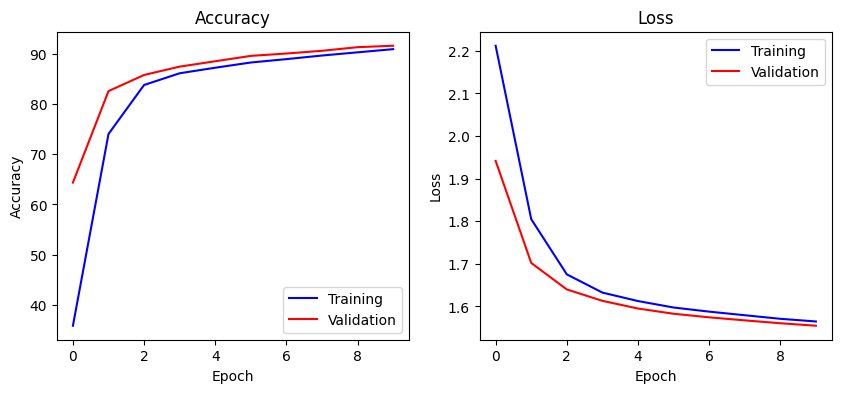

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].set_title("Accuracy")
axes[0].plot(range(epochs), train_acc_cnn, 'b', label='Training')
axes[0].plot(range(epochs), val_acc_cnn, 'r', label='Validation')
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].legend()

axes[1].set_title("Loss")
axes[1].plot(range(epochs), train_loss_cnn, 'b', label='Training')
axes[1].plot(range(epochs), val_loss_cnn, 'r', label='Validation')
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].legend()